In [7]:
import torch, pickle, argparse, os
import importlib
from fig_settings import *
from util import *
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import numpy as np
import seaborn as sns, glob

In [8]:
import numpy as np 
from scipy.integrate import simpson
from scipy.linalg import eigh
import math


def _flip(angles, index):
    for ii in range(index.shape[0]):
        if ii % 2 == 0:
            angles[index[ii, 0]:index[ii + 1, 0], index[ii, 1]] = math.pi - angles[index[ii, 0]:index[ii + 1, 0],
                                                                            index[ii, 1]]
    return angles


class memory_kernel_homogenized_model:
    def __init__(self, viscous=None, elastic=None, kernel=None, T=1.0):
        self._nu_p = viscous
        self._E_p = elastic
        self._kernel = kernel
        self._t = np.linspace(0.0, T, kernel.shape[0])
        self._dt = np.mean(self._t[1:] - self._t[:-1])

    def predict(self, ebar, rate):
        if isinstance(ebar, np.ndarray) and isinstance(ebar, np.ndarray):
            ebar_array = ebar
            rate_array = rate
        else:
            ebar_array = ebar(self._t)
            rate_array = rate(self._t)
        stress = np.zeros((self._t.size, self._nu_p.shape[0]))
        # stress[0] = self._nu_p @ rate_array[0]
        for ii, time in enumerate(self._t[1:]):
            step = ii + 1
            # stress[step] = self._nu_p @ rate_array[step] + self._E_p @ ebar_array[step]
            kernel_flip = np.flip(-self._kernel[:step + 1], 0)
            integrand = np.einsum("ijk, ik -> ij", kernel_flip, ebar_array[:step + 1])
            stress[step] += simpson(integrand, dx=self._dt, axis=0)
        return self._t, stress

    def eigen(self, type=None):
        if type == "viscous":
            s, basis = eigh(self._nu_p)
            angles = np.arccos(np.diagonal(np.abs(basis)))
            return s, angles
        elif type == "elastic":
            s, basis = eigh(self._E_p)
            angles = np.arccos(np.diagonal(np.abs(basis)))
            return s, angles
        elif type == "kernel":
            angles = np.zeros((self.nt+1, 3))
            s = np.zeros((self.nt+1, 3))
            for ii, time in enumerate(self._t):
                s[ii], basis = eigh(self._kernel[ii])
                angles[ii] = np.arccos(np.diagonal(np.abs(basis)))
            index = self._check_for_reflection(angles)
            angles = _flip(angles, index)
            return s, angles
        else:
            raise Exception("Wrong type. Must be viscous, elastic or kernel.")

    def _check_for_reflection(self, angles):
        angels_1st_rate = np.gradient(angles, self.dt, axis=0, edge_order=2)
        angels_2nd_rate = np.gradient(angels_1st_rate, self.dt, axis=0, edge_order=2)
        index = np.vstack(
            np.where(np.abs(angels_2nd_rate - np.mean(angels_2nd_rate, axis=0)) > 5 * np.std(angels_2nd_rate))).T[1::3]
        unique, count = np.unique(index[:, 1], return_counts=True)
        for ii, id in enumerate(unique):
            if count[ii] % 2 != 0:
                index = np.vstack((index, np.array([0, id])))
        for ii in range(2):
            index = index[index[:, ii].argsort()]
        return index

    @property
    def viscous(self):
        return self._nu_p

    @property
    def elastic(self):
        return self._E_p

    @property
    def kernel(self):
        return self._kernel

    @property
    def T(self):
        return self._t[-1]

    @property
    def dt(self):
        return self._dt

    @property
    def nt(self):
        return self._t.size-1

    @property
    def times(self):
        return self._t

In [3]:
run_id = 'material_model_run_n24' 
''
CKPT_PATH = glob.glob(run_id + '/vmm-epoch=*-train_rel_error=*.ckpt')[-1]
print(CKPT_PATH)
checkpoint = torch.load(CKPT_PATH, map_location='cpu', weights_only=True)

material_model_run_n24/vmm-epoch=299-train_rel_error=0.0000.ckpt


In [4]:
params = torch.load(run_id+'/args.pkl', weights_only=True)
args = argparse.Namespace(**params)  
folder = f'overleaf/figs/{run_id}' 
if not os.path.exists(folder):
    os.makedirs(folder)

In [5]:
data_file = args.data_path
content = open(data_file, "r").read().strip()
data_files = [file.strip() for file in content.split("\n")]

data0 = pickle.load(open(data_files[0], 'rb'))
data1 = pickle.load(open(data_files[1], 'rb'))
data2 = pickle.load(open(data_files[2], 'rb'))
data3 = pickle.load(open(data_files[3], 'rb'))
data_map = {0: data0, 1: data1, 2: data2, 3: data3}

relevant_cols = ['strain', 'strain_rate', 'stress', 'E', 'nu', 'E_prime', 'nu_prime', 'kernel']
data = {}
for col in relevant_cols:
    data[col] = []
    for i in range(4):
        data_i = data_map[i]
        if col in ['strain', 'strain_rate', 'stress', 'kernel']:
            data[col].append(data_i[col][:,::50]) 
        else:
            data[col].append(data_i[col])
    data[col] = np.concatenate(data[col], axis=0)


In [267]:
mm = importlib.import_module(run_id + '.' + args.material_model)
from util import LossFunction
from m_encoder import *
from lightning_script import *
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

In [268]:
mm = importlib.reload(mm)


In [269]:
encoder_input_dim = 501
ae_E = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
ae_nu = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
energy_input_dim = (1, args.niv, args.encoder_latent_dim * 2)
energy_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(","))
    )
dissipation_input_dim = energy_input_dim  # (p_dim, q_dim, m_dim)
dissipation_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(",")))
ae_E.freeze_encoder()
ae_nu.freeze_encoder()

vmm = mm.ViscoelasticMaterialModel(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
    dt = args.step/5000.0
).to(device)

In [270]:
lit = LitVMM.load_from_checkpoint(checkpoint_path=CKPT_PATH, model=vmm, name="vmm_", loss_type="mse")

In [271]:
# device = torch.device(args.device if torch.cuda.is_available() else "cpu")


# # data_files = [file.strip() for file in data_file.split(",")]
# # print(data_files)

# datasets = [
#     ViscoelasticDataset(
#         data_path=file,
#         step=args.step,
#         device=device,
#         encoder=False,
#     )
#     for file in data_files
# ]
# dataset = ConcatDataset(datasets)
# length = len(dataset)

# trainset = Subset(dataset, args.train_indices)
# valset = Subset(dataset, args.val_indices)
# testset = Subset(dataset, args.test_indices)
# loss_function = LossFunction()

In [272]:
E_features = vmm.E_encoder(torch.tensor(data['E'], dtype=torch.float32))
nu_features = vmm.E_encoder(torch.tensor(data['nu'], dtype=torch.float32))
m_features = torch.cat([E_features, nu_features], axis=1)
data['E_pred'] = vmm.energy_function.E(m_features).detach().numpy()
data['nu_pred']= vmm.dissipation_potential.nu(m_features).detach().numpy()
# data['A_pred']= vmm.energy_function.A(m_features).detach().numpy()
data['beta']= vmm.dissipation_potential.beta(m_features).detach().numpy()
x = (data['strain'], data['strain_rate'], data['E'], data['nu'])
x = map(lambda l: torch.tensor(l, dtype=torch.float32), (data['strain'], data['strain_rate'], data['E'], data['nu']))
data['s_pred'], data['xi_pred'] =  vmm(*x)
data['kernel_pred'] = np.zeros_like(data['kernel'])

In [273]:
error = (loss_function.L2RelativeError(data['s_pred'], torch.tensor(data['stress'], dtype=torch.float32), reduction=None)).squeeze().detach().numpy()
error_E = data['E_prime'].squeeze()- data['E_pred'].squeeze()
error_nu = data['nu_prime'].squeeze()- data['nu_pred'].squeeze()

In [274]:
np.mean(error), np.std(error)

(0.06079452, 0.036806658)

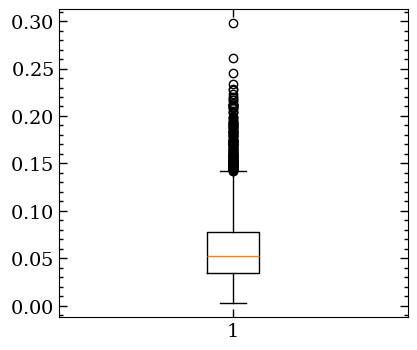

In [275]:
plt.boxplot(error)
plt.show()

In [276]:
np.mean(error_E), np.std(error_E), np.mean(error_nu), np.std(error_nu)

(1.193028945623808,
 0.16128324471096447,
 0.2286772871739792,
 0.12692407957914845)

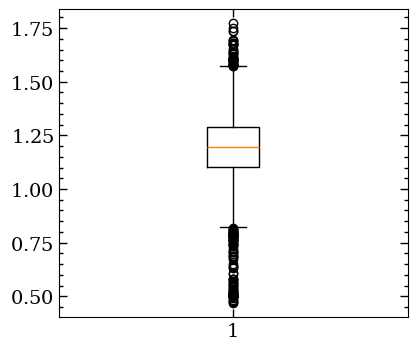

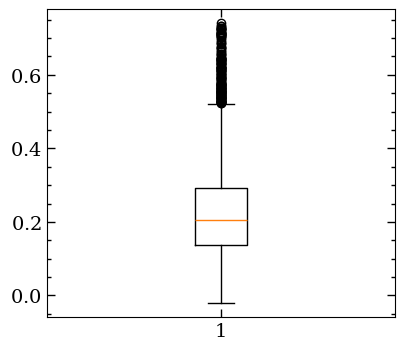

In [277]:
plt.boxplot(error_E)
plt.show()
plt.boxplot(error_nu)
plt.show()

In [278]:
np.mean(data['beta']), np.std(data['beta'])

(0.10345259, 0.051180054)

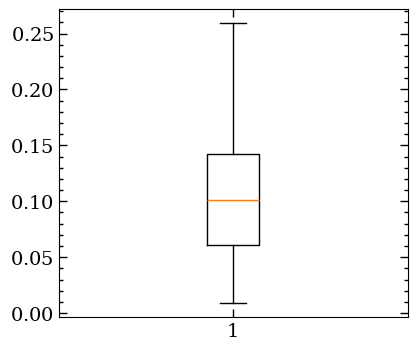

In [279]:
plt.boxplot(data['beta'])
plt.show()

-0.012586591 0.18031757


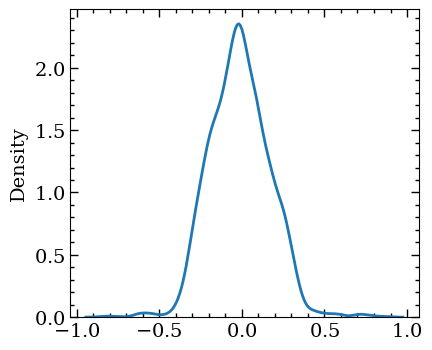

0.18467705 0.23759131


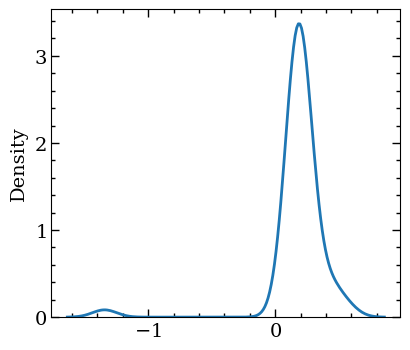

In [280]:
for layer in vmm.dissipation_potential.beta:
    try:
        weight = layer.weight.detach().numpy().flatten()
        sns.kdeplot(weight)
        print(np.mean(weight), np.std(weight))
        # k = np.sqrt(1/layer.in_features)
        # plt.plot([-k, k], [1/(2*k), 1/(2*k)], '--')
        plt.show()
    except:
        continue

In [290]:
onebynu = 1/data['nu']
# onebynu_shift = onebynu - np.mean(onebynu)

In [298]:
onebynu_mean = torch.tensor(np.mean(onebynu, axis=0), dtype=torch.float32)
onebynu_std = torch.tensor(np.std(onebynu, axis=0), dtype=torch.float32)

In [308]:
e_mean = torch.tensor(np.mean(data['nu'], axis=0), dtype=torch.float32)
e_std = torch.tensor(np.std(data['nu'], axis=0), dtype=torch.float32)

torch.save({'mean': e_mean, 'std': e_std}, 'mixture_random_field_process_nu_stats.pt')

In [301]:
torch.save({'mean': onebynu_mean, 'std': onebynu_std}, 'mixture_random_field_process_onebynu_stats.pt')

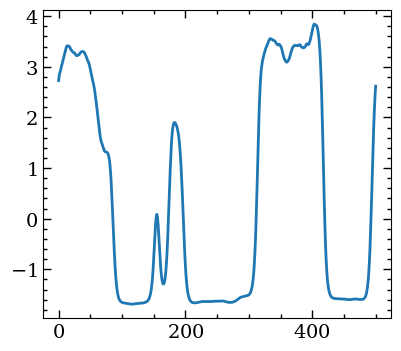

In [297]:
plt.plot(onebynu_shift[6])

In [315]:
nu_norm = (1/data['nu'] - onebynu_mean)/onebynu_std

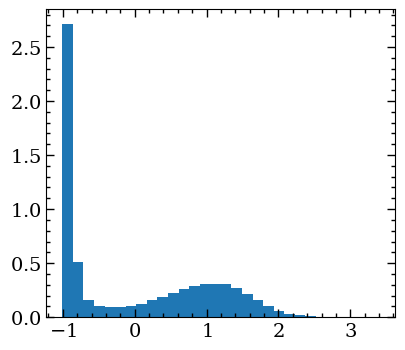

In [316]:
plt.hist(nu_norm.flatten(), bins=30, density=True)
plt.show()

In [181]:
import torch
import torch.nn as nn

class DeepAutoencoder1D(nn.Module):
    def __init__(self, input_channels, layer_channels, kernel_size=3, activation_fn=nn.ReLU):

        super().__init__()
        
        # --- ENCODER ---
        encoder_layers = []
        in_ch = input_channels

        for out_ch in layer_channels:
            encoder_layers.append(
                nn.Sequential(
                    nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(out_ch),
                    activation_fn(),
                    nn.MaxPool1d(2)
                )
            )
            in_ch = out_ch
            
        self.encoder = nn.Sequential(*encoder_layers)

        # --- DECODER ---
        decoder_layers = []
        reversed_channels = layer_channels[::-1]
        in_ch = reversed_channels[0]
        
        # Decoder body (excluding final layer)
        for out_ch in reversed_channels[1:]:
            decoder_layers.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(out_ch),
                    activation_fn()
                )
            )
            in_ch = out_ch
            
        self.decoder_body = nn.Sequential(*decoder_layers)
        
        # Final reconstruction layer
        self.final_layer = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_ch, input_channels, kernel_size, padding=kernel_size//2)
        )

    def forward(self, x):
        x = nn.functional.pad(x, (5, 6))  # Pad input to handle odd lengths
        latent = self.encoder(x)
        decoding = self.decoder_body(latent)
        return self.final_layer(decoding)[:,:, 6:-5]  # Remove padding after reconstruction
    


In [182]:
model = DeepAutoencoder1D(2, [128, 64, 32])

In [183]:
input_data = np.stack([data['nu'], data['E']], axis=1)[:2,:]  # Shape: (N, 2, 501)
input_tensor = torch.tensor(input_data, dtype=torch.float32)

In [307]:
input_data = np.stack([data['nu'], data['E']], axis=1) # Shape: (N, 2, 501)
input_tensor = torch.tensor(input_data, dtype=torch.float32)
train_set, val_set, test_set = random_split(input_tensor, [int(0.7*input_tensor.shape[0]), int(0.15*input_tensor.shape[0]), input_tensor.shape[0]-int(0.85*input_tensor.shape[0])])

In [317]:

epochs = 500
model = JointAutoEncoder(width=512, channels=[2, 32, 64, 128], latent_dim=49)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [318]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        recon = model(batch)
        loss = loss_fn(recon, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    train_loss /= len(train_loader.dataset)
    recon = model(input_tensor[test_set.indices])
    test_loss = loss_fn(recon, input_tensor[test_set.indices]).item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/500], Loss: 0.0948, Test Loss: 0.0186
Epoch [2/500], Loss: 0.0123, Test Loss: 0.0074
Epoch [3/500], Loss: 0.0061, Test Loss: 0.0045
Epoch [4/500], Loss: 0.0042, Test Loss: 0.0036
Epoch [5/500], Loss: 0.0037, Test Loss: 0.0031
Epoch [6/500], Loss: 0.0035, Test Loss: 0.0027
Epoch [7/500], Loss: 0.0031, Test Loss: 0.0025
Epoch [8/500], Loss: 0.0028, Test Loss: 0.0022
Epoch [9/500], Loss: 0.0025, Test Loss: 0.0021
Epoch [10/500], Loss: 0.0024, Test Loss: 0.0021
Epoch [11/500], Loss: 0.0024, Test Loss: 0.0021
Epoch [12/500], Loss: 0.0024, Test Loss: 0.0017
Epoch [13/500], Loss: 0.0021, Test Loss: 0.0017
Epoch [14/500], Loss: 0.0018, Test Loss: 0.0019
Epoch [15/500], Loss: 0.0019, Test Loss: 0.0014
Epoch [16/500], Loss: 0.0019, Test Loss: 0.0018
Epoch [17/500], Loss: 0.0018, Test Loss: 0.0028
Epoch [18/500], Loss: 0.0018, Test Loss: 0.0016
Epoch [19/500], Loss: 0.0017, Test Loss: 0.0013
Epoch [20/500], Loss: 0.0016, Test Loss: 0.0014
Epoch [21/500], Loss: 0.0015, Test Loss: 0.0014
E

KeyboardInterrupt: 

In [314]:
loss_function = LossFunction()

In [320]:
recon = model(input_tensor[test_set.indices])
loss_function.L2RelativeError(recon, input_tensor[test_set.indices])



tensor(0.0375, grad_fn=<MeanBackward0>)

In [354]:
model = nn.Sequential(nn.Linear(1002, 256), nn.ReLU(), nn.Linear(256, 1))

In [323]:
from sklearn.model_selection import train_test_split

In [360]:
input_data = np.concatenate((data['E'], data['nu']), axis=1)  # Shape: (N, 501)

output_data = data['E_prime'][:,0]  # Shape: (N, 1)
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

In [361]:
epochs = 5000


In [372]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    inputs = torch.tensor(x_train, dtype=torch.float32)
    targets = torch.tensor(y_train, dtype=torch.float32)
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    output = model(torch.tensor(x_test, dtype=torch.float32))
    test_loss = loss_fn(output, torch.tensor(y_test, dtype=torch.float32)).item()
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

Epoch [50/5000], Loss: 0.0093, Test Loss: 0.0111
Epoch [100/5000], Loss: 0.0030, Test Loss: 0.0066
Epoch [150/5000], Loss: 0.0023, Test Loss: 0.0062
Epoch [200/5000], Loss: 0.0023, Test Loss: 0.0061
Epoch [250/5000], Loss: 0.0022, Test Loss: 0.0061
Epoch [300/5000], Loss: 0.0022, Test Loss: 0.0061
Epoch [350/5000], Loss: 0.0022, Test Loss: 0.0061
Epoch [400/5000], Loss: 0.0022, Test Loss: 0.0061
Epoch [450/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [500/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [550/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [600/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [650/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [700/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [750/5000], Loss: 0.0022, Test Loss: 0.0062
Epoch [800/5000], Loss: 0.0021, Test Loss: 0.0062
Epoch [850/5000], Loss: 0.0021, Test Loss: 0.0062
Epoch [900/5000], Loss: 0.0021, Test Loss: 0.0062
Epoch [950/5000], Loss: 0.0021, Test Loss: 0.0062
Epoch [1000/5000], Loss: 0.0021, Test Loss: 0.0062


In [364]:
from sklearn.metrics import r2_score

In [373]:
output = model(torch.tensor(x_test, dtype=torch.float32)) 
print(r2_score(y_test, output.detach().numpy()))

output = model(torch.tensor(x_train, dtype=torch.float32)) 
print(r2_score(y_train, output.detach().numpy()))

0.7196853649933239
0.884421039905494


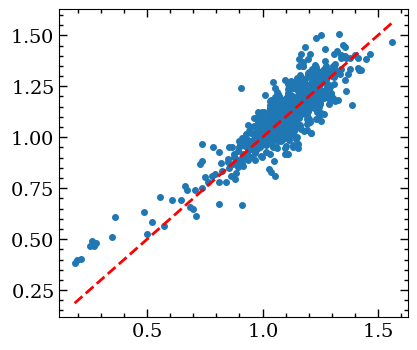

In [369]:
plt.scatter(y_test, output.detach().numpy())
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

0.735698992129179